In [ ]:
import os
import sklearn
import numpy as np
import pandas as pd
from glob import glob
import scipy.io as sio
from scipy import signal
from tqdm import tqdm

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier

import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchmetrics
from torch.nn import MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import torch.nn.functional as F


import matplotlib.pyplot as plt
import seaborn as sns

## Load data and create meta data

In [7]:
training_data_dir = "training/"
# training_data_dir = "/home/kurse/kurs00056/hz53kahe/physionet.org/files/challenge-2017/1.0.0/training2017/"

training_data_path = glob(training_data_dir+"*mat")
training_path_id_dic = { x.split('/')[-1].split('.')[0] : x for x in training_data_path}


reference = pd.read_csv(training_data_dir+"REFERENCE.csv",header=None)
reference = reference.rename(columns={0:'id',1:"label"})
reference_dic = dict(zip(reference['id'].to_list(),reference['label'].to_list() ) )

meta_pd = pd.DataFrame(columns=["id","path","label"])
meta_pd['id'] = training_path_id_dic.keys()
meta_pd['path'] = meta_pd['id'].map( training_path_id_dic.get )
meta_pd['label'] = meta_pd['id'].map(  reference_dic.get )
meta_pd['encoded_label'] = pd.Categorical(meta_pd['label']).codes

def get_mat(mat_path):
    s = sio.loadmat(mat_path)
    return s['val'][0]

meta_pd['data'] = meta_pd['path'].map( get_mat )
meta_pd['mean'] = meta_pd['data'].map( np.mean )
meta_pd['std'] = meta_pd['data'].map( np.std )
meta_pd['length'] = meta_pd['data'].map( np.shape )
# meta_pd['length'] = meta_pd['length'].values()

In [4]:
# meta_pd.tail(30)
# # meta_pd['length'][0]
# meta_pd[meta_pd['id']=='train_ecg_02130' ]['data'].to_list()[0]

## Data Visualization

### ratio of labels

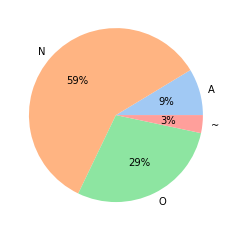

{'A': 738, 'N': 5050, 'O': 2456, '~': 284}

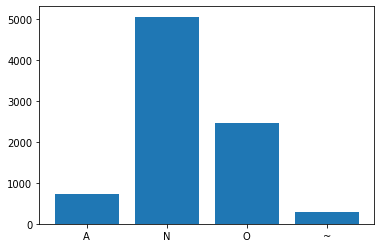

In [8]:

cates = pd.Categorical(meta_pd['label'], ordered=True).categories
cate_counts = meta_pd['encoded_label'].value_counts().to_list()

cate_counts_dic = dict(zip(cates, [len(meta_pd[meta_pd['label']==i]) for i in cates]))

plt.pie(cate_counts_dic.values(), labels = cate_counts_dic.keys(), colors = sns.color_palette('pastel')[0:4], autopct='%.0f%%')
plt.show()

fig, axs = plt.subplots()
axs.bar(cate_counts_dic.keys(), cate_counts_dic.values())


# for i  in cates:
#     print(i,len(meta_pd[meta_pd['label']==i]))

# # print(cates)
# # print(cate_counts)
cate_counts_dic

### length of data

In [9]:
MAX_LEN = meta_pd["length"].max()[0] #18286
MIN_LEN= meta_pd["length"].min()[0] ## 2714
len(meta_pd)

8528

In [ ]:
# test board for add new preprocessing components
# a plot for single training sample
sample_np = meta_pd[ meta_pd['id']=='train_ecg_04834' ].data.to_list()[0] # to get a array form data
# meta_pd[ meta_pd['id']=='train_ecg_00775' ].data.to_list()[0].shape[0]

# plt.plot(range(sample_np.shape[0]),sample_np)




sample_np_pad=  np.concatenate( (sample_np, np.ones(  MAX_LEN-sample_np.shape[0] ) *sample_np.mean()   ))
sample_np_pad=  np.pad(sample_np, (0,MAX_LEN-sample_np.shape[0]),  'reflect')


# print(len(sample_np_pad))
# plt.plot(range(sample_np_pad.shape[0]),sample_np_pad)


# # sample_np = preprocessing.Normalizer().fit_transform(sample_np.reshape(1, -1))
# # plt.plot(range(7302),sample_np.reshape(7302))

# # a = np.array([1,2,3])
# # b= np.pad(a,(0,15), 'wrap')
# # print( b )

sample_np_fft = np.abs( np.fft.rfft(sample_np_pad) )
sample_np_fft = preprocessing.Normalizer().fit_transform(sample_np_fft.reshape(1, -1))[0]
print(sample_np_fft.std())
# sample_np_fft = preprocessing.StandardScaler().fit_transform(sample_np_fft.reshape(1, -1))
sample_np_fft = (sample_np_fft-sample_np_fft.mean())/ sample_np_fft.std()
print((sample_np_fft.std()))
sample_np_fft.shape
plt.plot(range(sample_np_fft.shape[0]),sample_np_fft)

a= np.array([1,2,3,4,5])
a[:4]

### Perform Data preprocessing and store them in given path

In [14]:

import warnings
warnings.filterwarnings("ignore")
def data_len_norm(meta):
    '''
    Normalize the lengh of data follwing the idea from paper:
    https://res.mdpi.com/d_attachment/sensors/sensors-20-02136/article_deploy/sensors-20-02136.pdf
    
    Args:

        meta: pd.Dataframe, meta date in pd form.
    
    return:
        re: meta data after  processing
    
    '''
   
  
    
    re_pd = meta.copy()
    #print(len(re_pd))
    n = 0
    for row in re_pd.iterrows():
        if row[1]['length'][0] > 9000:
            adding_list = cut_recording(row[1]['data'])
            re_pd = re_pd.drop(row[0])
            for n in adding_list:
                new_recording = meta.iloc[row[0]].copy()
                new_recording['data'] = n
                #new_recording['id'] = 'extra_'+new_recording['id']
                new_recording['length'] = 9000
                # print(new_recording)
                re_pd = re_pd.append(new_recording,ignore_index = True)
                n+=1
               

            
      
        if row[1]['length'][0] < 9000:
            pass

    print(n)
    return re_pd


LENGTH_THRESHOLD = 9000


def cut_recording(ecg:np.array,length_threshold=9000):
    len_overlap = int(0.5*length_threshold)
    start = 0
    end = 9000
    re = []
    re.append(ecg[start:end])
    while True:
        if end+len_overlap > len(ecg):
            re.append(ecg[-9000:])
            break
        re.append(ecg[start+len_overlap:end+len_overlap])
        start +=len_overlap
        end+= len_overlap
        
        
    # print(ecg)
    
   
    return re


tmp_pd = data_len_norm(meta_pd)

[ -89  -98 -101 ...  -92  -67  -40]


In [15]:

tmp_pd.columns
meta_pd =tmp_pd 
meta_pd.columns
len(meta_pd)
meta_pd[meta_pd['id']=='extra_train_ecg_02130' ]
# meta_pd[meta_pd['id']=='train_ecg_02130' ]

,id,path,label,encoded_label,data,mean,std,length


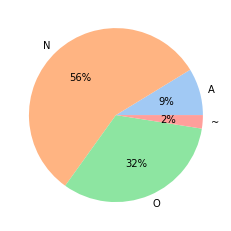

{'A': 1047, 'N': 6764, 'O': 3890, '~': 299}

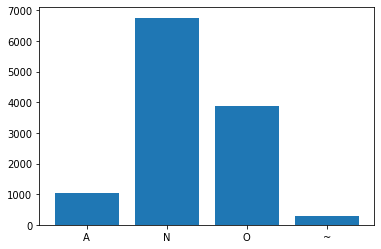

In [16]:

cates = pd.Categorical(meta_pd['label'], ordered=True).categories
cate_counts = meta_pd['encoded_label'].value_counts().to_list()

cate_counts_dic = dict(zip(cates, [len(meta_pd[meta_pd['label']==i]) for i in cates]))

plt.pie(cate_counts_dic.values(), labels = cate_counts_dic.keys(), colors = sns.color_palette('pastel')[0:4], autopct='%.0f%%')
plt.show()

fig, axs = plt.subplots()
axs.bar(cate_counts_dic.keys(), cate_counts_dic.values())


# for i  in cates:
#     print(i,len(meta_pd[meta_pd['label']==i]))

# # print(cates)
# # print(cate_counts)
cate_counts_dic

In [17]:
def preprocess(meta=meta_pd,to_path='precessed_data/normalized/',func_list=[],store = False):
    '''
    Perfrom the preprocessing to the data from given path and store the precessed data in given path
    
    Args:
        meta: like meta_pd which we created before
        from_path:  path contains *.mat data
        to_path: path where store the precessed data in npy form 
        func_list : aprroaches , which will be performed on the data.Notice that,  the approaches will be performed in given ordering
        store: bool, True to store the data, False for only return tmp_data
    return:
    '''
    # tmp_meta = pd.DataFrame()
    # tmp_meta['id'] = meta['id']
    
    tmp_meta = meta.copy()
    tmp_meta['to_path'] = to_path + meta['id']+'.npy'

    tmp_meta['preprocessed_data'] = meta['data']
    tmp_meta['preprocessed_data_wo_fft'] = meta['data']
    for f in func_list:
        tmp_meta['preprocessed_data'] = tmp_meta['preprocessed_data'].map(f)
        if f != ecg_fourier:
            tmp_meta['preprocessed_data_wo_fft'] = tmp_meta['preprocessed_data_wo_fft'].map(f)

  
    if store==True:
        for path,array in zip( tmp_meta['to_path'].to_list(),tmp_meta['preprocessed_data'].to_list()[0]):
            np.save( path,array  )
    
    
    #print(tmp_meta.head())
    return tmp_meta

def ecg_norm( ecg_np ):
    '''
    Be used in preprocess() to perform normalization
    
    Args:
        ecg_np: ecg data in np.array form in shape of (N,)
    
    return:
        re: processed data in array form
    
    '''
    ecg_np = ecg_np.reshape(1,-1)
    re = preprocessing.Normalizer().fit_transform(ecg_np)[0]-0.5

    return re

def ecg_pad( ecg_np ):
    '''
    Be used in preprocess() to perform padding (with mean by default )
    
    Args:
        ecg_np: ecg data in np.array form in shape of (N,)
    
    return:
        re: processed data in array form
    
    '''
   
    re = np.concatenate( ( ecg_np, np.ones(MAX_LEN -ecg_np.shape[0] )  *ecg_np.mean() ))
 
    return re

def ecg_pad_repeat( ecg_np ):
    '''
    Be used in preprocess() to perform padding (with mean by default )
    
    Args:
        ecg_np: ecg data in np.array form in shape of (N,)
    
    return:
        re: processed data in array form
    
    '''
   
    re = np.pad(ecg_np , (0,MAX_LEN-ecg_np.shape[0]),  'wrap')
    # low the avg scroes
    
    return re
def ecg_len_norm( ecg_np ):
    '''
    Be used in preprocess() to make the length be 9000 (over 9000 then cut, under 9000 then repeat)
    
    Args:
        ecg_np: ecg data in np.array form in shape of (N,)
    
    return:
        re: processed data in array form
    
    '''
    if len(ecg_np) < 9000:
        re = np.pad(ecg_np , (0,9000-ecg_np.shape[0]),  'wrap')
    elif len(ecg_np) >9000 :
        re = ecg_np[:9000]
        # print(len(ecg_np))
    else :
        re = ecg_np

    
    return re

def ecg_fourier( ecg_np ):
    '''
    Be used in preprocess() to perform Fourier Transform
    
    Args:
        ecg_np: ecg data in np.array form in shape of (N,)
    
    return:
        re: processed data in array form
    
    '''
   

    re = np.abs(np.fft.rfft(ecg_np))
 
    return re


def ecg_stand( ecg_np ):
    '''
    Be used in preprocess() to perform Standardize
    
    Args:
        ecg_np: ecg data in np.array form in shape of (N,)
    
    return:
        re: processed data in array form
    
    '''
   
    re = (ecg_np-ecg_np.mean())/ ecg_np.std()
    return re

def data_ros(meta, cc_dict ):
    '''
    Be used in preprocess() to perform Rondom over sampling. To address the imbalance problem.
    
    Args:
        cc_dict: dict, for cate_counts_dic
        meta: pd.Dataframe, meta date in pd form.
    
    return:
        re: meta data after ros
    
    '''
   
  
    
    data_aug_ratio_dic =dict( zip(cc_dict.keys()  , (np.array([*cc_dict.values()]).max() / np.array([*cc_dict.values()])).round() )   ) 
    
    print(data_aug_ratio_dic)
    re_pd = meta.copy()
    
    for (l,r )in data_aug_ratio_dic.items():
        # print(l,r)
        re_pd = re_pd.append( [meta.loc[ meta['label'] == l,:]] * int(r-1) ,ignore_index=True)
    
    print((re_pd['encoded_label'].value_counts().values.max()/re_pd['encoded_label'].value_counts().values).round())

    
    
    return re_pd

# preprocess(meta=meta_pd[:3],func_list=[ecg_norm, ecg_pad], store = True)
# meta_pd_ros = data_ros(meta_pd,cate_counts_dic )

In [18]:
meta_pd.tail()


,id,path,label,encoded_label,data,mean,std,length
11995,A06819,/home/kurse/kurs00056/hz53kahe/physionet.org/f...,O,2,"[-31, -31, -31, -32, -32, -32, -32, -32, -32, ...",15.242722,148.126692,9000
11996,A00613,/home/kurse/kurs00056/hz53kahe/physionet.org/f...,A,0,"[-320, -369, -390, -407, -405, -362, -258, -12...",35.235056,183.789602,9000
11997,A00613,/home/kurse/kurs00056/hz53kahe/physionet.org/f...,A,0,"[492, 366, 248, 143, 50, -25, -79, -111, -124,...",35.235056,183.789602,9000
11998,A00613,/home/kurse/kurs00056/hz53kahe/physionet.org/f...,A,0,"[-89, -98, -101, -103, -94, -79, -67, -63, -61...",35.235056,183.789602,9000
11999,A00613,/home/kurse/kurs00056/hz53kahe/physionet.org/f...,A,0,"[-89, -98, -101, -103, -94, -79, -67, -63, -61...",35.235056,183.789602,9000


In [19]:
meta_precessed_pd=None
meta_precessed_pd = preprocess(meta=meta_pd,func_list=[ecg_len_norm,ecg_norm])


In [20]:
# len(meta_precessed_pd)
meta_precessed_pd

,id,path,label,encoded_label,data,mean,std,length,to_path,preprocessed_data,preprocessed_data_wo_fft
0,A06456,/home/kurse/kurs00056/hz53kahe/physionet.org/f...,O,2,"[-682, -806, -921, -1014, -1045, -1030, -920, ...",20.717000,194.775029,"(9000,)",precessed_data/normalized/A06456.npy,"[-0.5367017688310106, -0.5433748177093761, -0....","[-0.5367017688310106, -0.5433748177093761, -0...."
1,A02900,/home/kurse/kurs00056/hz53kahe/physionet.org/f...,A,0,"[-169, -184, -220, -269, -326, -382, -409, -44...",80.244111,398.319050,"(9000,)",precessed_data/normalized/A02900.npy,"[-0.5043842531091519, -0.5047733880004968, -0....","[-0.5043842531091519, -0.5047733880004968, -0...."
2,A04871,/home/kurse/kurs00056/hz53kahe/physionet.org/f...,N,1,"[-218, -275, -338, -401, -457, -500, -517, -52...",3.449667,173.430316,"(9000,)",precessed_data/normalized/A04871.npy,"[-0.5132472071834246, -0.5167109264928522, -0....","[-0.5132472071834246, -0.5167109264928522, -0...."
3,A01704,/home/kurse/kurs00056/hz53kahe/physionet.org/f...,N,1,"[-325, -389, -452, -512, -547, -556, -563, -56...",19.587000,235.235330,"(9000,)",precessed_data/normalized/A01704.npy,"[-0.5145130682468904, -0.5173710263016627, -0....","[-0.5145130682468904, -0.5173710263016627, -0...."
4,A01051,/home/kurse/kurs00056/hz53kahe/physionet.org/f...,N,1,"[122, 143, 152, 159, 165, 172, 176, 179, 181, ...",9.317444,122.448214,"(9000,)",precessed_data/normalized/A01051.npy,"[-0.4895279324497183, -0.48772536344516165, -0...","[-0.4895279324497183, -0.48772536344516165, -0..."
...,...,...,...,...,...,...,...,...,...,...,...
11995,A06819,/home/kurse/kurs00056/hz53kahe/physionet.org/f...,O,2,"[-31, -31, -31, -32, -32, -32, -32, -32, -32, ...",15.242722,148.126692,9000,precessed_data/normalized/A06819.npy,"[-0.5028452193578722, -0.5028452193578722, -0....","[-0.5028452193578722, -0.5028452193578722, -0...."
11996,A00613,/home/kurse/kurs00056/hz53kahe/physionet.org/f...,A,0,"[-320, -369, -390, -407, -405, -362, -258, -12...",35.235056,183.789602,9000,precessed_data/normalized/A00613.npy,"[-0.5172204041272586, -0.519857278509245, -0.5...","[-0.5172204041272586, -0.519857278509245, -0.5..."
11997,A00613,/home/kurse/kurs00056/hz53kahe/physionet.org/f...,A,0,"[492, 366, 248, 143, 50, -25, -79, -111, -124,...",35.235056,183.789602,9000,precessed_data/normalized/A00613.npy,"[-0.471606533305089, -0.4788780308732979, -0.4...","[-0.471606533305089, -0.4788780308732979, -0.4..."
11998,A00613,/home/kurse/kurs00056/hz53kahe/physionet.org/f...,A,0,"[-89, -98, -101, -103, -94, -79, -67, -63, -61...",35.235056,183.789602,9000,precessed_data/normalized/A00613.npy,"[-0.5052466137162044, -0.505777170159416, -0.5...","[-0.5052466137162044, -0.505777170159416, -0.5..."


### Split the data into training , val and test set

In [21]:
# meta_precessed_pd = preprocess(meta=meta_pd,func_list=[ecg_pad,ecg_norm]) # get 0.55 and 0.52 in rf for acc and avg f1

# meta_precessed_pd = preprocess(meta=meta_pd,func_list=[ecg_pad_repeat,ecg_norm,ecg_fourier]) # get 0.58 and 0.56 on mlp 


# meta_precessed_pd = preprocess(meta=meta_pd,func_list=[ecg_len_norm,ecg_fourier,ecg_norm,ecg_stand])

train_pd,  test_pd = train_test_split(meta_precessed_pd, test_size=0.3, random_state=42,stratify =meta_precessed_pd['encoded_label'] )
# print(train_pd.head())


train_pd_ros = data_ros(train_pd,cate_counts_dic )

X_train_pd = train_pd_ros['preprocessed_data_wo_fft']
y_train_pd = train_pd_ros['encoded_label']
X_val_pd, X_test_pd, y_val_pd, y_test_pd = train_test_split(test_pd['preprocessed_data_wo_fft'], test_pd['encoded_label'], test_size=0.33, random_state=42,stratify = test_pd['encoded_label'])



def pd_2array(X_pd,y_pd):
    '''
    Convert DataFrema to np.array
    
    
    Args:
        X_pd:X in datafrema form, each row is one np.array data
        y_pd: y in datafrema form, each row is a single number
    
    return:
        X,y in np.array form 
    '''
    X_ = []
    y_ = []
    for X,y in zip( X_pd,y_pd):
        X_.append(X.tolist())
        y_.append(y) 

    return np.array(X_),np.array(y_)


X_train , y_train = pd_2array(X_train_pd, y_train_pd)
X_val , y_val = pd_2array(X_val_pd, y_val_pd)
X_test , y_test = pd_2array(X_test_pd, y_test_pd)


{'A': 6.0, 'N': 1.0, 'O': 2.0, '~': 23.0}
[1. 1. 1. 1.]


In [ ]:
len(X_train[0])
# y_train[:5]

9000

In [15]:
meta_precessed_pd.columns
# meta_precessed_pd['preprocessed_data'][0].shape

Index(['id', 'path', 'label', 'encoded_label', 'data', 'mean', 'std', 'length',
       'to_path', 'preprocessed_data', 'preprocessed_data_wo_fft'],
      dtype='object')

### Test on some simple ML models

In [22]:
clf = RandomForestClassifier(max_depth=10, random_state=42,n_jobs = -1)
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
print(classification_report(y_train, y_train_pred))

y_val_pred = clf.predict(X_val)
print(classification_report(y_val, y_val_pred))


              precision    recall  f1-score   support

           0       1.00      0.84      0.91      4398
           1       1.00      0.68      0.81      4735
           2       0.71      1.00      0.83      5446
           3       1.00      1.00      1.00      4807

    accuracy                           0.88     19386
   macro avg       0.93      0.88      0.89     19386
weighted avg       0.92      0.88      0.89     19386

              precision    recall  f1-score   support

           0       1.00      0.21      0.35       210
           1       0.71      0.32      0.44      1360
           2       0.37      0.84      0.52       782
           3       1.00      0.10      0.18        60

    accuracy                           0.47      2412
   macro avg       0.77      0.37      0.37      2412
weighted avg       0.63      0.47      0.45      2412



In [ ]:
# def RL(X_train_rl, y_train_rl,X_val_rl,y_val_rl,X_test_rl,y_test_rl):
#     '''
#     A Random forest classifier:
        
#     '''
#     clf = RandomForestClassifier(max_depth=10, random_state=42,n_jobs = -1)
#     clf.fit(X_train_rl, y_train_rl)
#     y_train_pred = clf.predict(X_train_rl)
#     print("--------Random forest classifier--------")
#     print("*****f1-score metrix on training set*****")
#     print(classification_report(y_train_rl, y_train_pred))

#     y_val_pred = clf.predict(X_val_rl)
#     print("*****f1-score metrix on val set*****")
#     print(classification_report(y_val_rl, y_val_pred))
    
#     y_test_pred = clf.predict(X_test_rl)
#     print("*****f1-score metrix on test set*****")
#     print(classification_report(y_test_rl, y_test_pred))

# RL(X_train, y_train,X_val,y_val,X_test,y_test)

In [ ]:
#clf = MLPClassifier(random_state=43, hidden_layer_sizes= (300,200,100,50),max_iter=1000,learning_rate ='adaptive' ).fit(X_train, y_train)

# clf = MLPClassifier( hidden_layer_sizes= (300,200,100,50),early_stopping = True,max_iter=1000,learning_rate ='adaptive' ).fit(X_train, y_train)


# y_train_pred = clf.predict(X_train)
# print(classification_report(y_train, y_train_pred))

# y_val_pred = clf.predict(X_val)
# print(classification_report(y_val, y_val_pred))


In [ ]:
# def MLP(X_train_mlp, y_train_mlp,X_val_mlp,y_val_mlp,X_test_mlp,y_test_mlp):
#     '''
#     A MLP classifier:
        
#     '''
#     clf = AdaBoostClassifier(n_estimators=100).fit(X_train_mlp, y_train_mlp)

#     y_train_pred = clf.predict(X_train_mlp)
#     print("--------MLP classifier--------")
#     print("*****f1-score metrix on training set*****")
#     print(classification_report(y_train_mlp, y_train_pred))

#     y_val_pred = clf.predict(X_val_mlp)
#     print("*****f1-score metrix on val set*****")
#     print(classification_report(y_val_mlp, y_val_pred))
    
#     y_test_pred = clf.predict(X_test_mlp)
#     print("*****f1-score metrix on test set*****")
#     print(classification_report(y_test_mlp, y_test_pred))

# RL(X_train, y_train,X_val,y_val,X_test,y_test)

In [ ]:
# clf = AdaBoostClassifier(n_estimators=100).fit(X_train, y_train)

# y_train_pred = clf.predict(X_train)
# print(classification_report(y_train, y_train_pred))

# y_val_pred = clf.predict(X_val)
# print(classification_report(y_val, y_val_pred))

In [ ]:
# clf1 = LogisticRegression(random_state=1)
# clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
# clf3 = GaussianNB()
# clf4 = AdaBoostClassifier(n_estimators=100)
# clf5 = MLPClassifier(random_state=43, max_iter=1000)

# eclf = VotingClassifier(
#     estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3),('ada',clf4),('m;p',clf5)],
#     voting='hard',n_jobs = -1).fit(X_train, y_train)

# # for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
# #     scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
# #     print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

# y_train_pred = eclf.predict(X_train)
# print(classification_report(y_train, y_train_pred))

# y_val_pred = eclf.predict(X_val)
# print(classification_report(y_val, y_val_pred))

### 1D CNN model

In [ ]:
import torch
print(torch.__version__)

1.11.0+cu102


In [ ]:
# print(y_train_pd.head())
# print(X_train_pd.head())
# X_train_pd.head()


print(y_train_pd.head(10))
y_train[:10]


print(X_train_pd.head(10))
len(X_train[1])

0    3
1    1
2    2
3    1
4    2
5    1
6    2
7    2
8    2
9    2
Name: encoded_label, dtype: int8
0    [-0.5068612926736724, -0.5086480876407745, -0....
1    [-0.48884841322843875, -0.48713278449435243, -...
2    [-0.4992578113244744, -0.4991796862007349, -0....
3    [-0.5087331682535241, -0.5107641376148089, -0....
4    [-0.4960635803336355, -0.49520472513370145, -0...
5    [-0.482258716565533, -0.48220148661897017, -0....
6    [-0.5025922829944869, -0.5026462888902054, -0....
7    [-0.49699048964593323, -0.4967829372077217, -0...
8    [-0.49128891162650795, -0.49092289950997464, -...
9    [-0.5042545387709347, -0.5062276582009335, -0....
Name: preprocessed_data_wo_fft, dtype: object


9000

In [ ]:
class ecg_Dataset(Dataset):
    def __init__(self, X_pd,y_pd):
        """
        Args:

        """
        self.X_pd = X_pd
        self.y_pd = y_pd
        
    def __len__(self):
        return len(self.X_pd)

    def __getitem__(self, idx):

        return self.X_pd.iloc[idx], self.y_pd.iloc[idx]

ecg_train_dataset = ecg_Dataset(X_train_pd,y_train_pd)
ecg_train_dataloader = DataLoader(ecg_train_dataset, batch_size=1000)
next(iter(ecg_train_dataloader))[0].shape


torch.Size([1000, 9000])

In [ ]:
BATCH_SIZE = 64
LR = 1e-4

In [ ]:
# class MyModel(pl.LightningModule):
#     def __init__(
#             self,
#             num_inputs,
#             num_hidden_1,
#             num_hidden_2,
#             num_hidden_3,
#             num_hidden_4,
#             num_outputs,
#             dataloaders,
#     ):
#         super().__init__()

#         self.linear1 = nn.Linear(num_inputs, num_hidden_1)
#         self.ac1 = nn.ReLU()

#         self.linear2 = nn.Linear(num_hidden_1, num_hidden_2)
#         self.ac2 = nn.ReLU()

#         self.linear3 = nn.Linear(num_hidden_2, num_hidden_3)
#         self.ac3 = nn.ReLU()

#         self.linear4 = nn.Linear(num_hidden_3, num_hidden_4)
#         self.ac4 = nn.ReLU()

#         self.out = nn.Linear(num_hidden_4, num_outputs)

#         self.softmax = nn.Softmax(dim=1)

#         self.criterion = nn.CrossEntropyLoss()

#         self.train_accuracy = torchmetrics.F1Score()

#         self.val_accuracy = torchmetrics.F1Score()
#         self.test_accuracy = torchmetrics.F1Score()
#         self.dataloaders = dataloaders

#     def forward(self, inputs, labels=None):

#         inputs = inputs.float()

#         outputs = self.linear1(inputs)
#         outputs = self.ac1(outputs)

#         outputs = self.linear2(outputs)
#         outputs = self.ac2(outputs)

#         outputs = self.linear3(outputs)
#         outputs = self.ac3(outputs)

#         outputs = self.linear4(outputs)
#         outputs = self.ac4(outputs)

#         outputs = self.out(outputs)

#         outputs = self.softmax(outputs)

#         return outputs
#     def predict_step(self, batch, batch_idx):
#         inputs, labels = batch

#         labels = labels.long()

#         outputs = self(inputs)

#         # outputs = torch.argmax(outputs, dim=1)

#         preds = torch.argmax(outputs, dim=1)



#         return preds


#     def train_dataloader(self):
#         # ecg_train_dataset = ecg_Dataset(X_train_pd, y_train_pd)
#         # return DataLoader(ecg_train_dataset, batch_size=100)

#         return self.dataloaders[0]

#     def val_dataloader(self):
#         # ecg_val_dataset = ecg_Dataset(X_val_pd, y_val_pd)
#         # return DataLoader(ecg_val_dataset, batch_size=100)

#         return self.dataloaders[1]

#     def test_dataloader(self):
#         # ecg_test_dataset = ecg_Dataset(X_test_pd, y_test_pd)
#         # return DataLoader(ecg_test_dataset, batch_size=100)
#         return self.dataloaders[2]

#     def training_step(self, batch, batch_idx):
#         inputs, labels = batch

#         labels = labels.long()

#         outputs = self(inputs)

#         # outputs = torch.argmax(outputs, dim=1)

#         preds = torch.argmax(outputs, dim=1)
#         # print(preds)
#         self.train_accuracy(preds, labels)

#         # print("training acc:",self.train_accuracy(outputs, labels))
#         loss = self.criterion(outputs, labels)
#         # print("trainingh Loss:",loss)

#         self.log("train_loss", loss)

#         return loss

#     def validation_step(self, batch, batch_idx):
#         inputs, labels = batch
#         # inputs = inputs.long().view(inputs.size(0), -1)
#         labels = labels.long()

#         outputs = self(inputs)
#         # outputs = torch.argmax(outputs, dim=1)
#         preds = torch.argmax(outputs, dim=1)
#         self.val_accuracy(preds, labels)
#         # print("val acc:",self.val_accuracy(outputs, labels))
#         # print("total val acc:",self.val_accuracy.compute())

#         loss = self.criterion(outputs, labels)
#         # print("VAL Loss:",loss)

#         self.log("val_loss", loss)

#     def validation_epoch_end(self, outs):
#         print("total val acc:", self.val_accuracy.compute())
#         print("*" * 25)

#     def training_epoch_end(self, outs):
#         # print(   compute_epoch_loss_from_outputs(outs))
#         print("total training acc:", self.train_accuracy.compute())

#     def configure_optimizers(self):
#         decayRate = 0.96
#         optimizer = Adam(self.parameters(), lr=LR)
#         scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

#         return [optimizer], [scheduler]

#     def test_step(self, batch, batch_idx):
#         inputs, labels = batch
#         # inputs = inputs.long().view(inputs.size(0), -1)
#         labels = labels.long()

#         outputs = self(inputs)
#         # outputs = torch.argmax(outputs, dim=1)
#         preds = torch.argmax(outputs, dim=1)

#         # print(preds)

#         self.test_accuracy(preds, labels)

#     def test_epoch_end(self, outs):
#         # print(   compute_epoch_loss_from_outputs(outs))
#         print("total test acc:", self.test_accuracy.compute())

# ecg_train_dataset = ecg_Dataset(X_train_pd, y_train_pd)
# ecg_train_dataloader = DataLoader(ecg_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# ecg_val_dataset = ecg_Dataset(X_val_pd, y_val_pd)
# ecg_val_dataloader = DataLoader(ecg_val_dataset, batch_size=BATCH_SIZE, shuffle=True)

# ecg_test_dataset = ecg_Dataset(X_test_pd, y_test_pd)
# ecg_test_dataloader = DataLoader(ecg_test_dataset, batch_size=BATCH_SIZE, shuffle=True)


# model = MyModel(4501,3000,2000, 1000, 500, 4, [ecg_train_dataloader, ecg_val_dataloader, ecg_test_dataloader])
# trainer = pl.Trainer(accelerator="gpu", devices=1, max_epochs=50, gpus=0)  #

#     # trainer = pl.Trainer(accelerator="gpu", devices=1, max_epochs=1000, gpus=0,callbacks=[EarlyStopping(monitor="val_loss", mode="min")]) #
# trainer.fit(model)
# # torch.save(model, "tmp/saved_model")
# trainer.validate(model)
# trainer.test(model)



In [ ]:
# class _SepConv1d(nn.Module):
#     """A simple separable convolution implementation.

#     The separable convlution is a method to reduce number of the parameters
#     in the deep learning network for slight decrease in predictions quality.
#     """

#     def __init__(self, ni, no, kernel, stride, pad):
#         super().__init__()
#         self.depthwise = nn.Conv1d(ni, ni, kernel, stride, padding=pad, groups=ni)
#         self.pointwise = nn.Conv1d(ni, no, kernel_size=1)

#     def forward(self, x):
#         return self.pointwise(self.depthwise(x))


# class SepConv1d(nn.Module):
#     """Implementes a 1-d convolution with 'batteries included'.

#     The module adds (optionally) activation function and dropout layers right after
#     a separable convolution layer.
#     """

#     def __init__(
#         self,
#         ni,
#         no,
#         kernel,
#         stride,
#         pad,
#         drop=None,
#         activ=lambda: nn.ReLU(inplace=True),
#     ):

#         super().__init__()
#         assert drop is None or (0.0 < drop < 1.0)
#         layers = [_SepConv1d(ni, no, kernel, stride, pad)]
#         if activ:
#             layers.append(activ())
#         if drop is not None:
#             layers.append(nn.Dropout(drop))
#         self.layers = nn.Sequential(*layers)

#     def forward(self, x):
#         return self.layers(x)


# class Flatten(nn.Module):
#     """Converts N-dimensional tensor into 'flat' one."""

#     def __init__(self, keep_batch_dim=True):
#         super().__init__()
#         self.keep_batch_dim = keep_batch_dim

#     def forward(self, x):
#         if self.keep_batch_dim:
#             return x.view(x.size(0), -1)
#         return x.view(-1)

In [ ]:

class ecg_Dataset_v2(Dataset):
    def __init__(self, X_pd,X_wo_fft_pd,y_pd):
        """
        Return Data with fft and without fft
        Args:

        """
        self.X_pd = X_pd
        self.X_wo_fft_pd = X_wo_fft_pd
        self.y_pd = y_pd
        
    def __len__(self):
        return len(self.X_pd)

    def __getitem__(self, idx):

        return self.X_pd.iloc[idx],self.X_wo_fft_pd.iloc[idx], self.y_pd.iloc[idx]

    
# meta_precessed_pd = preprocess(meta=meta_pd,func_list=[ecg_len_norm,ecg_fourier,ecg_norm,ecg_stand])

# train_pd,  test_pd = train_test_split(meta_precessed_pd, test_size=0.3, random_state=42,stratify =meta_precessed_pd['encoded_label'] )
# # print(train_pd.head())
# train_pd_ros = data_ros(train_pd,cate_counts_dic )

X_train_pd = train_pd_ros['preprocessed_data']
y_train_pd = train_pd_ros['encoded_label']
X_train_wo_fft_pd = train_pd_ros['preprocessed_data_wo_fft']

X_val_pd, X_test_pd, y_val_pd, y_test_pd = train_test_split(test_pd[['preprocessed_data','preprocessed_data_wo_fft']], test_pd['encoded_label'], test_size=0.33, random_state=42,stratify = test_pd['encoded_label'])


X_val_pd.reset_index(inplace=True)
X_val_wo_fft_pd = X_val_pd['preprocessed_data_wo_fft']
X_val_pd = X_val_pd['preprocessed_data']

X_test_pd.reset_index(inplace=True)
X_test_wo_fft_pd = X_test_pd['preprocessed_data_wo_fft']
X_test_pd = X_test_pd['preprocessed_data']


BATCH_SIZE = 16

ecg_train_dataset = ecg_Dataset_v2(X_train_pd,X_train_wo_fft_pd,y_train_pd)
ecg_train_dataloader = DataLoader(ecg_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

ecg_val_dataset = ecg_Dataset_v2(X_val_pd,X_val_wo_fft_pd, y_val_pd)
ecg_val_dataloader = DataLoader(ecg_val_dataset, batch_size=BATCH_SIZE, shuffle=True)

ecg_test_dataset = ecg_Dataset_v2(X_test_pd, X_test_wo_fft_pd ,y_test_pd)
ecg_test_dataloader = DataLoader(ecg_test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# class MyModel_1dCNN(pl.LightningModule):
#     def __init__(self, cin_raw,cin_fft, num_outputs, drop,  dataloaders):
#         super().__init__()

#         self.seq_fft= nn.Sequential(
#             SepConv1d(cin_raw, 32, 8, 2, 3, drop=drop), # cin 24
#             SepConv1d(32, 64, 8, 4, 2, drop=drop),
#             SepConv1d(64, 128, 8, 4, 2, drop=drop),
#             SepConv1d(128, 256, 8, 4, 2),
#             Flatten(),
#             nn.Dropout(drop),
#             nn.Linear(8960, 3000), # 18176
#             nn.ReLU(inplace=True),
#             nn.Dropout(drop),
#             nn.Linear(3000, 1500),
#             nn.ReLU(inplace=True),
        
#         )

#         self.seq_raw = nn.Sequential(
#             SepConv1d(cin_fft,  32, 8, 2, 4, drop=drop),
#             SepConv1d(    32,  64, 8, 2, 4, drop=drop),
#             SepConv1d(    64, 128, 8, 4, 4, drop=drop),
#             SepConv1d(   128, 128, 8, 4, 4, drop=drop),
#             SepConv1d(   128, 256, 8, 2, 3),
#             Flatten(),
#             nn.Dropout(drop), nn.Linear(17920, 3000), nn.ReLU(inplace=True),
#             nn.Dropout(drop), nn.Linear( 3000, 1500), nn.ReLU(inplace=True),)
        
#         # self.out = nn.Linear(64, num_outputs)
        
#         self.out = nn.Sequential(
#             nn.Linear(3000, 2000), nn.ReLU(inplace=True), 
#             nn.Linear(2000, 1000), nn.ReLU(inplace=True),
#             nn.Linear(1000, 500), nn.ReLU(inplace=True),
#             nn.Linear(500, num_outputs), nn.ReLU(inplace=True)
#         )

#         self.criterion = nn.CrossEntropyLoss()

#         self.train_accuracy = torchmetrics.F1Score()

#         self.val_accuracy = torchmetrics.F1Score()
        
#         self.test_accuracy = torchmetrics.F1Score()
#         self.dataloaders = dataloaders

#     def forward(self, inputs,inputs_wo_fft, labels=None):

#         inputs = inputs.float()
#         inputs_wo_fft = inputs_wo_fft.float()
#         # print(inputs.shape)
#         outputs_fft = self.seq_fft(inputs)
#         outputs_raw = self.seq_raw(inputs_wo_fft)
        
#         # outputs_fft = self.seq_fft(inputs)
#         outputs = torch.cat([outputs_raw,outputs_fft],dim=1)

    
#         return outputs

#     def train_dataloader(self):
#         # ecg_train_dataset = ecg_Dataset(X_train_pd, y_train_pd)
#         # return DataLoader(ecg_train_dataset, batch_size=100)

#         return self.dataloaders[0]

#     def val_dataloader(self):
#         # ecg_val_dataset = ecg_Dataset(X_val_pd, y_val_pd)
#         # return DataLoader(ecg_val_dataset, batch_size=100)

#         return self.dataloaders[1]

#     def test_dataloader(self):
#         # ecg_test_dataset = ecg_Dataset(X_test_pd, y_test_pd)
#         # return DataLoader(ecg_test_dataset, batch_size=100)
#         return self.dataloaders[2]

#     def training_step(self, batch, batch_idx):

#         inputs,inputs_wo_fft, labels = batch
#         inputs = inputs
#         inputs_wo_fft = inputs_wo_fft
        
#         inputs = inputs.reshape(inputs.shape[0],1,inputs.shape[1])
#         inputs_wo_fft  = inputs_wo_fft.reshape(inputs_wo_fft.shape[0],1,inputs_wo_fft.shape[1])
#         #print(inputs.shape)
#         labels = labels.long()

#         outputs = self(inputs,inputs_wo_fft)
#         preds = F.log_softmax(outputs, dim=1).argmax(dim=1)
#         #preds = torch.argmax(outputs, dim=1)
#         #print(preds.shape)

        
#         self.train_accuracy(preds, labels)
        

#         #print("training acc:",self.train_accuracy(outputs, labels))
#         loss = self.criterion(outputs, labels)

#         self.log("train_loss", loss)

#         return loss

#         # loss, outputs = self(inputs, labels)
#         # return {"loss": loss}

#     def validation_step(self, batch, batch_idx):

#         inputs,inputs_wo_fft, labels = batch
#         inputs = inputs
#         inputs_wo_fft = inputs_wo_fft
#         inputs = inputs.reshape(inputs.shape[0],1,inputs.shape[1])
        
#         inputs_wo_fft  = inputs_wo_fft.reshape(inputs_wo_fft.shape[0],1,inputs_wo_fft.shape[1])
#         #print(inputs.shape)
#         labels = labels.long()

#         outputs = self(inputs,inputs_wo_fft)
#         preds = F.log_softmax(outputs, dim=1).argmax(dim=1)
#         #print(preds.shape)

        
#         self.val_accuracy(preds, labels)
      
        

#         # print("val acc:",self.val_accuracy(outputs, labels))
#         # print("total val acc:",self.val_accuracy.compute())

#         loss = self.criterion(outputs, labels)

#         self.log("val_loss", loss)

#     def validation_epoch_end(self, outs):
#         print("total val acc:", self.val_accuracy.compute())
#         # print(self.val_f1_matrix)
#         #print("*" * 25)

#     def training_epoch_end(self, outs):
#         #pass
#         print("total training acc:", self.train_accuracy.compute())

#     def configure_optimizers(self):

#         optimizer = Adam(self.parameters(),lr=0.0001)
#         return optimizer

#     def test_step(self, batch, batch_idx):
#         inputs,inputs_wo_fft, labels = batch
#         inputs = inputs
#         inputs_wo_fft = inputs_wo_fft
#         inputs = inputs.reshape(inputs.shape[0],1,inputs.shape[1])
        
#         inputs_wo_fft  = inputs_wo_fft.reshape(inputs_wo_fft.shape[0],1,inputs_wo_fft.shape[1])
#         #print(inputs.shape)
#         labels = labels.long()

#         outputs = self(inputs,inputs_wo_fft)
#         preds = F.log_softmax(outputs, dim=1).argmax(dim=1)
#         #print(preds.shape)

        
#         self.test_accuracy(preds, labels)
#     def test_epoch_end(self, outs):
#         # print(   compute_epoch_loss_from_outputs(outs))
#         print("total test acc:", self.test_accuracy.compute())  


# if __name__ == "__main__":
#     model = MyModel_1dCNN(1,1, 4, drop=0.3, dataloaders=[ecg_train_dataloader, ecg_val_dataloader, ecg_test_dataloader])
#     trainer = pl.Trainer(accelerator="gpu", devices=1, max_epochs=200, gpus=0,)
#     trainer.fit(model)
    
#     trainer.test(model)


In [ ]:
# drop = 0.1
# seq_raw=  nn.Sequential(
#             SepConv1d(1,  32, 8, 2, 4, drop=drop),
#             SepConv1d(    32,  64, 8, 2, 4, drop=drop),
#             SepConv1d(    64, 128, 8, 4, 4, drop=drop),
#             SepConv1d(   128, 128, 8, 4, 4, drop=drop),
#             SepConv1d(   128, 256, 8, 2, 3),
# Flatten(),)
# a= torch.rand([1,1,9000])
# b= seq_raw(a)
# b.shape

## 1d cnn from paper

In [ ]:
cin_fft = 1
k_size = 5
seq_fft = nn.Sequential(
    nn.Conv1d(cin_fft,32,k_size),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(32),
    nn.MaxPool1d(2),

    nn.Conv1d(32,32,k_size),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(2),

    nn.Conv1d(32,64,k_size),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(2),

    nn.Conv1d(64,64,k_size),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(2),

    nn.Conv1d(64,128,k_size),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(2),

    nn.Conv1d(128,128,k_size),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(2),

    nn.Conv1d(128,256,k_size),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(2),

    nn.Conv1d(256,256,k_size),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    nn.Conv1d(256,512,k_size),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(2),

    nn.Conv1d(512,512,k_size),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    nn.Flatten(),
    # nn.Linear(2048,128),
    # nn.ReLU(inplace=True),
    # nn.Dropout(0.5),
    # nn.Linear(128,32),
    # nn.ReLU(inplace=True),
    # nn.Linear(32,4),
    # nn.Softmax(dim=1)
        
        )
a = torch.rand([10,1,9000])
b = seq_fft(a)
b.shape
b= b.reshape(b.shape[0],b.shape[1],1)
b.shape #(10,2048,1)



torch.Size([10, 2048, 1])

In [ ]:
# bs =10
# in_fea = 1
# len = 9000
# hs= 1
# num_layers = 2
# c = torch.rand([batch_size,len,in_fea])

# rnn = nn.LSTM(in_fea, hs, num_layers,batch_first = True,bidirectional = True)
# input = c
# h0 = torch.randn(2*num_layers,batch_size, hs)
# c0 = torch.randn(2*num_layers, batch_size, hs)
# output, (hn, cn) = rnn(input, (h0, c0))
# output.shape

In [23]:
class ecg_Dataset(Dataset):
    def __init__(self, X_pd,y_pd):
        """
        Args:

        """
        self.X_pd = X_pd
        self.y_pd = y_pd
        
    def __len__(self):
        return len(self.X_pd)

    def __getitem__(self, idx):

        return self.X_pd.iloc[idx], self.y_pd.iloc[idx]


class MyModel(pl.LightningModule):
    def __init__(
            self,
            cin,
            cout,

            dataloaders,
    ):
        super().__init__()

        self.cin= cin,
        self.example_input_array = torch.rand(1,1,9000)
        self.cout=cout

        

        self.criterion = nn.CrossEntropyLoss()

        self.train_accuracy = torchmetrics.F1Score(num_classes=4, average ='weighted')

        self.val_accuracy = torchmetrics.F1Score(num_classes=4, average ='weighted')
        self.test_accuracy = torchmetrics.F1Score(num_classes=4, average ='weighted')
        self.dataloaders = dataloaders
    
        self.feature_extractor =  nn.Sequential(
    nn.Conv1d(1,32,5),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(32),
    nn.MaxPool1d(2),

    nn.Conv1d(32,32,5),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(2),

    nn.Conv1d(32,64,5),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(2),

    nn.Conv1d(64,64,5),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(2),

    nn.Conv1d(64,128,5),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(2),

    nn.Conv1d(128,128,5),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(2),

    nn.Conv1d(128,256,5),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(2),

    nn.Conv1d(256,256,5),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    nn.Conv1d(256,512,5),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(2),

    nn.Conv1d(512,512,5),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    nn.Flatten(),
        )
    
        self.classifier =  nn.Sequential(
            nn.Linear(2048,128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128,32),
    nn.ReLU(inplace=True),
    nn.Linear(32,self.cout),
    nn.Softmax(dim=1))

    def get_feature(self, inputs):

        features = self.feature_extractor(inputs)
        # print('feature shape:',features.shape)
        return features 


    def forward(self, inputs, labels=None):

        inputs = inputs.float()

        #outputs = self.seq_fft(inputs)

        outputs = self.feature_extractor(inputs)
        outputs = self.classifier(outputs)

        

        return outputs

    def predict_step(self, batch, batch_idx):
        inputs, labels = batch

        labels = labels.long()

        outputs = self(inputs)

        # outputs = torch.argmax(outputs, dim=1)

        preds = torch.argmax(outputs, dim=1)



        return preds


    def train_dataloader(self):
        # ecg_train_dataset = ecg_Dataset(X_train_pd, y_train_pd)
        # return DataLoader(ecg_train_dataset, batch_size=100)

        return self.dataloaders[0]

    def val_dataloader(self):
        # ecg_val_dataset = ecg_Dataset(X_val_pd, y_val_pd)
        # return DataLoader(ecg_val_dataset, batch_size=100)

        return self.dataloaders[1]

    def test_dataloader(self):
        # ecg_test_dataset = ecg_Dataset(X_test_pd, y_test_pd)
        # return DataLoader(ecg_test_dataset, batch_size=100)
        return self.dataloaders[2]

    def training_step(self, batch, batch_idx):
        inputs, labels = batch

        inputs=inputs.reshape(inputs.shape[0],1,inputs.shape[1])
        #print(inputs.shape)
        labels = labels.long()

        outputs = self(inputs)

        # outputs = torch.argmax(outputs, dim=1)

        preds = torch.argmax(outputs, dim=1)
        # print(preds)
        self.train_accuracy(preds, labels)

        # print("training acc:",self.train_accuracy(outputs, labels))
        loss = self.criterion(outputs, labels)
        # print("trainingh Loss:",loss)

        self.log("train_loss", loss)
        

        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        inputs=inputs.reshape(inputs.shape[0],1,inputs.shape[1])
        # inputs = inputs.long().view(inputs.size(0), -1)
        labels = labels.long()

        outputs = self(inputs)
        # outputs = torch.argmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)
        self.val_accuracy(preds, labels)
        # print("val acc:",self.val_accuracy(outputs, labels))
        # print("total val acc:",self.val_accuracy.compute())

        loss = self.criterion(outputs, labels)
        # print("VAL Loss:",loss)
        #self.val_f1_matrix = classification_report(labels.cpu(),preds.cpu())

        self.log("val_loss", loss)

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        inputs=inputs.reshape(inputs.shape[0],1,inputs.shape[1])

        # inputs = inputs.long().view(inputs.size(0), -1)
        labels = labels.long()

        outputs = self(inputs)
        # outputs = torch.argmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)
        #print(preds)
        self.test_f1_matrix = classification_report(labels.cpu(),preds.cpu())

        # print(preds)

        self.test_accuracy(preds, labels)
    def validation_epoch_end(self, outs):
        self.log("val_f1",self.val_accuracy.compute())
        print("total val acc:", self.val_accuracy.compute())
        #print(self.val_f1_matrix)
        print("*" * 25)

    def training_epoch_end(self, outs):
        # print(   compute_epoch_loss_from_outputs(outs))
        self.log("training_f1",self.train_accuracy.compute())
        print("total training acc:", self.train_accuracy.compute())


    def test_epoch_end(self, outs):
        # print(   compute_epoch_loss_from_outputs(outs))
        print("total test acc:", self.test_accuracy.compute())
        print(self.test_f1_matrix)


    def configure_optimizers(self):
        decayRate = 0.96
        optimizer = Adam(self.parameters(), lr=LR)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

        return [optimizer], [scheduler]

    
LR = 1e-4  
BATCH_SIZE =30
ecg_train_dataset = ecg_Dataset(X_train_pd, y_train_pd)
ecg_train_dataloader = DataLoader(ecg_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

ecg_val_dataset = ecg_Dataset(X_val_pd, y_val_pd)
ecg_val_dataloader = DataLoader(ecg_val_dataset, batch_size=BATCH_SIZE, shuffle=True)

ecg_test_dataset = ecg_Dataset(X_test_pd, y_test_pd)
ecg_test_dataloader = DataLoader(ecg_test_dataset, batch_size=1000, shuffle=True)





In [24]:
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger("tb_logs",log_graph=True,name="BS")
model = MyModel(1,4, [ecg_train_dataloader, ecg_val_dataloader, ecg_test_dataloader])
# print(model)
trainer = pl.Trainer(accelerator="gpu", devices=1, max_epochs=1, gpus=0,logger= logger)  #

    # trainer = pl.Trainer(accelerator="gpu", devices=1, max_epochs=1000, gpus=0,callbacks=[EarlyStopping(monitor="val_loss", mode="min")]) #
trainer.fit(model)
# torch.save(model, "tmp/saved_model")
trainer.validate(model)
trainer.test(model)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type             | Params | In sizes     | Out sizes
----------------------------------------------------------------------------------
0 | criterion         | CrossEntropyLoss | 0      | ?            | ?        
1 | train_accuracy    | F1Score          | 0      | ?            | ?        
2 | val_accuracy      | F1Score          | 0      | ?            | ?        
3 | test_accuracy     | F1Score          | 0      | ?            | ?        
4 | feature_extractor | Sequential       | 2.6 M  | [1, 1, 9000] | [1, 2048]
5 | classifier        | Sequential       | 266 K  | [1, 2048]    | [1, 4]   
----------------------------------------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.540    Total estimated 

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]total val acc: tensor(0.0182, device='cuda:0')
*************************
Epoch 0: 100%|██████████| 728/728 [00:18<00:00, 40.38it/s, loss=1.16, v_num=7]total val acc: tensor(0.4810, device='cuda:0')
*************************
Epoch 0: 100%|██████████| 728/728 [00:18<00:00, 40.19it/s, loss=1.16, v_num=7]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 81/81 [00:00<00:00, 101.71it/s]total val acc: tensor(0.4846, device='cuda:0')
*************************
Validation DataLoader 0: 100%|██████████| 81/81 [00:00<00:00, 101.63it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_f1             0.4845898747444153
        val_loss             1.228154182434082
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]total test acc: tensor(0.4741, device='cuda:0')
              precision    recall  f1-score   support

           0       0.23      0.50      0.31        20
           1       0.63      0.70      0.67       105
           2       0.50      0.05      0.09        60
           3       0.14      1.00      0.25         3

    accuracy                           0.48       188
   macro avg       0.38      0.56      0.33       188
weighted avg       0.54      0.48      0.44       188

Testing DataLoader 0: 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


[{}]

In [ ]:
# EP = [10,50,100,150,200,300]

# # EP = [1,2,3]
# for ep in EP:
#     logger = TensorBoardLogger("tb_logs",log_graph=True,name=f"BS_{ep}")
#     model = MyModel(1,4, [ecg_train_dataloader, ecg_val_dataloader, ecg_test_dataloader])
#     # print(model)
#     trainer = pl.Trainer(accelerator="gpu", devices=1, max_epochs=ep, gpus=0,logger= logger)  #

#         # trainer = pl.Trainer(accelerator="gpu", devices=1, max_epochs=1000, gpus=0,callbacks=[EarlyStopping(monitor="val_loss", mode="min")]) #
#     trainer.fit(model)
#     # torch.save(model, "tmp/saved_model")
#     trainer.validate(model)
#     trainer.test(model)
    

### prepare QRS data for LSTM 

In [ ]:
import neurokit2 as nk
from sklearn.preprocessing import Normalizer
fs = 300

transformer = Normalizer()

meta_precessed_pd['clean'] = meta_precessed_pd['preprocessed_data'].apply(nk.ecg_clean,sampling_rate = fs)
## get mean, std, min, max of cleaned data
meta_precessed_pd['clean_mean'] = meta_precessed_pd['clean'].apply(np.mean)
meta_precessed_pd['clean_std'] = meta_precessed_pd['clean'].apply(np.std)
meta_precessed_pd['clean_max'] = meta_precessed_pd['clean'].apply(np.max)
meta_precessed_pd['clean_min'] = meta_precessed_pd['clean'].apply(np.min)

## get the distance between max and min
meta_precessed_pd['clean_dist'] =meta_precessed_pd['clean_max']-meta_precessed_pd['clean_min']
meta_precessed_pd['clean_dist'] = meta_precessed_pd['clean_dist'].apply(np.abs)
meta_precessed_pd.head()


def get_segment(ecg_np):
    '''
    
    Args:
        ecg_np: np.array, cleaned ecg data, (9000)
    

    Return:
        Segment: np.array, 
    '''
    ecg_np = transformer.fit_transform(ecg_np.reshape(1, -1)).reshape(9000)
    _, rpeaks = nk.ecg_peaks(ecg_np.reshape(9000), sampling_rate=300, correct_artifacts=True,method='promac')
    # elgendi2010,
    epochs = nk.ecg_segment(ecg_np, rpeaks=rpeaks["ECG_R_Peaks"], sampling_rate=300)
    seg_len = len(epochs['1']['Signal'].values)
    seg = np.zeros([1,seg_len])
    for i in epochs.values():
        if True in np.isnan(i['Signal'].values):
            pass
        else:
            seg += transformer.fit_transform(i['Signal'].values.reshape(1, -1)) 


    seg = transformer.fit_transform(seg.reshape(1,-1))
    return seg.reshape(seg_len)

meta_precessed_pd['hb_seg'] = meta_precessed_pd['clean'].map(get_segment)
meta_precessed_pd['seg_len'] = meta_precessed_pd['hb_seg'].map(len)

In [26]:
meta_precessed_pd['seg_len'] = meta_precessed_pd['hb_seg'].map(len)
meta_precessed_pd['hb_seg'] = meta_precessed_pd['hb_seg'].apply(signal.resample,num=300)
meta_precessed_pd.head()

meta_precessed_pd.to_csv('meta_precessed_pd.csv')

In [27]:
# 
meta_precessed_pd_loaded = pd.read_csv('meta_precessed_pd.csv',delimiter=",")
meta_precessed_pd_loaded.columns
# meta_pd.columns
# meta_precessed_pd = meta_precessed_pd_loaded

Index(['Unnamed: 0', 'id', 'path', 'label', 'encoded_label', 'data', 'mean',
       'std', 'length', 'to_path', 'preprocessed_data',
       'preprocessed_data_wo_fft', 'clean', 'clean_mean', 'clean_std',
       'clean_max', 'clean_min', 'clean_dist', 'hb_seg', 'seg_len'],
      dtype='object')

### CNN + LSTM model


In [28]:
# X_train_pd.head()
# meta_precessed_pd.columns
# meta_precessed_pd['hb_seg'] = [ np.random.rand(300) for i in range(len(meta_precessed_pd))]
# len(meta_precessed_pd)
# meta_precessed_pd['hb_seg']

train_pd,  test_pd = train_test_split(meta_precessed_pd, test_size=0.3, random_state=42,stratify =meta_precessed_pd['encoded_label'] )
train_pd_ros = data_ros(train_pd,cate_counts_dic )

X_train_pd = train_pd_ros[['preprocessed_data_wo_fft','hb_seg']]
X_train_hb_pd = X_train_pd['hb_seg']
X_train_pd = X_train_pd['preprocessed_data_wo_fft']

y_train_pd = train_pd_ros['encoded_label']
X_val_pd, X_test_pd, y_val_pd, y_test_pd = train_test_split(test_pd[['preprocessed_data_wo_fft','hb_seg']], test_pd['encoded_label'], test_size=0.33, random_state=42,stratify = test_pd['encoded_label'])

# X_train_hb_pd
# X_train_pd
X_val_hb_pd= X_val_pd['hb_seg']
X_val_pd= X_val_pd['preprocessed_data_wo_fft']

X_test_hb_pd= X_test_pd['hb_seg']
X_test_pd= X_test_pd['preprocessed_data_wo_fft']


{'A': 6.0, 'N': 1.0, 'O': 2.0, '~': 23.0}
[1. 1. 1. 1.]


In [41]:
len(X_test_pd)

1188

In [29]:
len(meta_precessed_pd.iloc[3]['hb_seg'])
X_train_pd.iloc[1]
# X_train_pd.head()
# type(meta_pd['data'].iloc[1])

array([-0.49935428, -0.49911214, -0.49895071, ..., -0.50032286,
       -0.50104929, -0.50169501])

In [ ]:
class ecg_Dataset(Dataset):
    def __init__(self, X_pd,y_pd,hb_pd):
        """
        Args:

        """
        self.X_pd = X_pd
        self.y_pd = y_pd
        self.hb_pd = hb_pd
        
    def __len__(self):
        return len(self.X_pd)

    def __getitem__(self, idx):

        return self.X_pd.iloc[idx], self.y_pd.iloc[idx], self.hb_pd.iloc[idx]

ecg_train_dataset = ecg_Dataset(X_train_pd,y_train_pd,X_train_hb_pd)
ecg_train_dataloader = DataLoader(ecg_train_dataset, batch_size=1)
# print(next(iter(ecg_train_dataloader)))
for i in next(iter(ecg_train_dataloader)):
    
    print(type(i))
    print(i)


In [42]:
class MyModel(pl.LightningModule):
    def __init__(
            self,
            cin,
            cout,
            lstm_in,
            lstm_size,
            lstm_layer_num,

            dataloaders,
    ):
        super().__init__()

        self.cin= cin,
        #self.example_input_array = torch.rand(1,1,9000)
        self.cout=cout

        self.lstm_in = lstm_in,
        self.lstm_size = lstm_size,
        self.lstm_layer_num = lstm_layer_num,

        

        self.criterion = nn.CrossEntropyLoss()

        self.train_accuracy = torchmetrics.F1Score(num_classes=4, average ='weighted')

        self.val_accuracy = torchmetrics.F1Score(num_classes=4, average ='weighted')
        self.test_accuracy = torchmetrics.F1Score(num_classes=4, average ='weighted')
        self.dataloaders = dataloaders
    
        self.feature_extractor =  nn.Sequential(
    nn.Conv1d(1,32,5),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(32),
    nn.MaxPool1d(2),

    nn.Conv1d(32,32,5),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(2),

    nn.Conv1d(32,64,5),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(2),

    nn.Conv1d(64,64,5),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(2),

    nn.Conv1d(64,128,5),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(2),

    nn.Conv1d(128,128,5),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(2),

    nn.Conv1d(128,256,5),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(2),

    nn.Conv1d(256,256,5),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    nn.Conv1d(256,512,5),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(2),

    nn.Conv1d(512,512,5),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    nn.Flatten(),
        )
        self.bilstm = nn.Sequential(
            #self.lstm_in, self.lstm_size, self.lstm_layer_num,
        nn.LSTM(lstm_in, lstm_size, lstm_layer_num,batch_first = True,bidirectional = True),
        extract_tensor(),
        nn.Flatten()  )
        self.classifier =  nn.Sequential(
            nn.Linear(5048,128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128,32),
            nn.ReLU(inplace=True),
            nn.Linear(32,self.cout),
            nn.Softmax(dim=1))

    def get_feature(self, inputs):

        features = self.feature_extractor(inputs)
        # print('feature shape:',features.shape)
        return features 


    def forward(self, inputs,lstm_inputs, labels=None):

        inputs = inputs.float()
        lstm_inputs = lstm_inputs.float()
        #outputs = self.seq_fft(inputs)

        outputs = self.feature_extractor(inputs)
        # print(lstm_inputs.shape)
        lstm_outputs = self.bilstm(lstm_inputs)
        # print(outputs.shape) #[bs,2048]
        # print(lstm_outputs.shape) # [bs,3000]
        outputs = torch.cat((outputs,lstm_outputs),dim=1)
        outputs = self.classifier(outputs)

        

        return outputs

    def predict_step(self, batch, batch_idx):
        inputs, labels,lstm_inputs = batch
        lstm_inputs = lstm_inputs.reshape(lstm_inputs.shape[0],lstm_inputs.shape[1],1)
        inputs=inputs.reshape(inputs.shape[0],1,inputs.shape[1])


        labels = labels.long()

        outputs = self(inputs,lstm_inputs)

        # outputs = torch.argmax(outputs, dim=1)

        preds = torch.argmax(outputs, dim=1)



        return preds


    def train_dataloader(self):
        # ecg_train_dataset = ecg_Dataset(X_train_pd, y_train_pd)
        # return DataLoader(ecg_train_dataset, batch_size=100)

        return self.dataloaders[0]

    def val_dataloader(self):
        # ecg_val_dataset = ecg_Dataset(X_val_pd, y_val_pd)
        # return DataLoader(ecg_val_dataset, batch_size=100)

        return self.dataloaders[1]

    def test_dataloader(self):
        # ecg_test_dataset = ecg_Dataset(X_test_pd, y_test_pd)
        # return DataLoader(ecg_test_dataset, batch_size=100)
        return self.dataloaders[2]

    def training_step(self, batch, batch_idx):
        inputs, labels,lstm_inputs = batch
        # print(lstm_inputs.shape) # [batch_size,300]
        lstm_inputs = lstm_inputs.reshape(lstm_inputs.shape[0],lstm_inputs.shape[1],1)
        #print(lstm_inputs.shape) # [batch_size,300,1]
        inputs=inputs.reshape(inputs.shape[0],1,inputs.shape[1])
        #print(inputs.shape)
        labels = labels.long()

        outputs = self(inputs,lstm_inputs)

        # outputs = torch.argmax(outputs, dim=1)

        preds = torch.argmax(outputs, dim=1)
        # print(preds)
        self.train_accuracy(preds, labels)

        # print("training acc:",self.train_accuracy(outputs, labels))
        loss = self.criterion(outputs, labels)
        # print("trainingh Loss:",loss)

        self.log("train_loss", loss)
        

        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels,lstm_inputs = batch
        inputs=inputs.reshape(inputs.shape[0],1,inputs.shape[1])
        # inputs = inputs.long().view(inputs.size(0), -1)

        lstm_inputs = lstm_inputs.reshape(lstm_inputs.shape[0],lstm_inputs.shape[1],1)
        labels = labels.long()

        outputs = self(inputs,lstm_inputs)
        # outputs = torch.argmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)
        self.val_accuracy(preds, labels)
        # print("val acc:",self.val_accuracy(outputs, labels))
        # print("total val acc:",self.val_accuracy.compute())

        loss = self.criterion(outputs, labels)
        # print("VAL Loss:",loss)
        #self.val_f1_matrix = classification_report(labels.cpu(),preds.cpu())

        self.log("val_loss", loss)

    def test_step(self, batch, batch_idx):
        inputs, labels,lstm_inputs = batch
        inputs=inputs.reshape(inputs.shape[0],1,inputs.shape[1])
        lstm_inputs = lstm_inputs.reshape(lstm_inputs.shape[0],lstm_inputs.shape[1],1)
        # inputs = inputs.long().view(inputs.size(0), -1)
        labels = labels.long()

        outputs = self(inputs,lstm_inputs)
        # outputs = torch.argmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)
        #print(preds)
        self.test_f1_matrix = classification_report(labels.cpu(),preds.cpu())

        # print(preds)

        self.test_accuracy(preds, labels)
    def validation_epoch_end(self, outs):
        self.log("val_f1",self.val_accuracy.compute())
        print("total val acc:", self.val_accuracy.compute())
        #print(self.val_f1_matrix)
        print("*" * 25)

    def training_epoch_end(self, outs):
        # print(   compute_epoch_loss_from_outputs(outs))
        self.log("training_f1",self.train_accuracy.compute())
        print("total training acc:", self.train_accuracy.compute())


    def test_epoch_end(self, outs):
        # print(   compute_epoch_loss_from_outputs(outs))
        print("total test acc:", self.test_accuracy.compute())
        print(self.test_f1_matrix)


    def configure_optimizers(self):
        decayRate = 0.96
        optimizer = Adam(self.parameters(), lr=LR)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

        return [optimizer], [scheduler]


class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args
    def forward(self, x):
        return x.view(x.shape[1],1)
class extract_tensor(nn.Module):
    def forward(self,x):
        # Output shape (batch, features, hidden)
        out,hs_cs = x
        # Reshape shape (batch, hidden)
        return out

LR = 1e-4  
BATCH_SIZE =30
ecg_train_dataset = ecg_Dataset(X_train_pd, y_train_pd,X_train_hb_pd)
ecg_train_dataloader = DataLoader(ecg_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

ecg_val_dataset = ecg_Dataset(X_val_pd, y_val_pd,X_val_hb_pd)
ecg_val_dataloader = DataLoader(ecg_val_dataset, batch_size=BATCH_SIZE, shuffle=True)

ecg_test_dataset = ecg_Dataset(X_test_pd, y_test_pd,X_test_hb_pd)
ecg_test_dataloader = DataLoader(ecg_test_dataset, batch_size=2000, shuffle=True)





In [32]:
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger("tb_logs",log_graph=True,name="CNN_LSTM")
model = MyModel(cin=1,cout=4, lstm_in=1,lstm_size=5,lstm_layer_num=2, dataloaders=[ecg_train_dataloader, ecg_val_dataloader, ecg_test_dataloader])
# print(model)
trainer = pl.Trainer(accelerator="gpu", devices=1, max_epochs=100, gpus=0,logger= logger)  #

# trainer = pl.Trainer(accelerator="gpu", devices=1, max_epochs=1000, gpus=0,callbacks=[EarlyStopping(monitor="val_loss", mode="min")]) #
trainer.fit(model)
# torch.save(model, "tmp/saved_model")
trainer.validate(model)
trainer.test(model)
# trainer.predict(model, dataloaders=ecg_test_dataloader)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type             | Params
-------------------------------------------------------
0 | criterion         | CrossEntropyLoss | 0     
1 | train_accuracy    | F1Score          | 0     
2 | val_accuracy      | F1Score          | 0     
3 | test_accuracy     | F1Score          | 0     
4 | feature_extractor | Sequential       | 2.6 M 
5 | bilstm            | Sequential       | 1.0 K 
6 | classifier        | Sequential       | 650 K 
-------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.080    Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  5.04it/s]total val acc: tensor(0.0005, device='cuda:0')
*************************
Epoch 0: 100%|██████████| 728/728 [00:30<00:00, 23.67it/s, loss=1.14, v_num=25]total val acc: tensor(0.4839, device='cuda:0')
*************************
Epoch 1: 100%|██████████| 728/728 [00:30<00:00, 23.85it/s, loss=1.12, v_num=25]total val acc: tensor(0.5502, device='cuda:0')
*************************
Epoch 2: 100%|██████████| 728/728 [00:30<00:00, 23.94it/s, loss=1.01, v_num=25] total val acc: tensor(0.5562, device='cuda:0')
*************************
Epoch 3: 100%|██████████| 728/728 [00:30<00:00, 24.00it/s, loss=1.02, v_num=25] total val acc: tensor(0.5841, device='cuda:0')
*************************
Epoch 4: 100%|██████████| 728/728 [00:30<00:00, 23.96it/s, loss=0.993, v_num=25]total val acc: tensor(0.6149, device='cuda:0')
*************************
Epoch 5: 100%|██████████| 728/728 [00:30<00:00, 23.94it/s, loss=0.939, v_num=25]total val

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 81/81 [00:01<00:00, 52.89it/s]total val acc: tensor(0.6920, device='cuda:0')
*************************
Validation DataLoader 0: 100%|██████████| 81/81 [00:01<00:00, 52.81it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_f1             0.6920296549797058
        val_loss             0.972978413105011
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  4.88it/s]total test acc: tensor(0.7474, device='cuda:0')
              precision    recall  f1-score   support

           0       0.73      0.89      0.80        18
           1       0.83      0.87      0.85       105
           2       0.79      0.61      0.69        62
           3       0.38      1.00      0.55         3

    accuracy                           0.79       188
   macro avg       0.68      0.84      0.72       188
weighted avg       0.80      0.79      0.79       188

Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  7.57it/s]


[{}]

In [43]:
    saved_model = MyModel(cin=1,cout=4, lstm_in=1,lstm_size=5,lstm_layer_num=2, dataloaders=[])

    saved_model.load_state_dict(torch.load('mymodel'))
    trainer = pl.Trainer(accelerator="gpu", devices=1, gpus=0)
    print("getting the predictions...")
    trainer.test(saved_model, dataloaders=ecg_test_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


getting the predictions...
Testing DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]total test acc: tensor(0.9148, device='cuda:0')
              precision    recall  f1-score   support

           0       0.89      0.94      0.92       104
           1       0.94      0.95      0.94       669
           2       0.90      0.85      0.88       385
           3       0.77      0.90      0.83        30

    accuracy                           0.91      1188
   macro avg       0.87      0.91      0.89      1188
weighted avg       0.92      0.91      0.91      1188

Testing DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


[{}]

## Get deep feature from CNN

In [ ]:
## Get deep feature from CNN
model = MyModel(1,4, [ecg_train_dataloader, ecg_val_dataloader, ecg_test_dataloader])

model.get_feature(torch.tensor(range(9000)).reshape([1,1,9000]).float())

# def get_cnn_feature(ecg_np):
#     fea = model.get_feature(torch.from_numpy(ecg_np.reshape([1,1,len(ecg_np)])).float())
#     fea = fea.reshape(fea.shape[1]) # shoudl be 9000
#     return fea
# meta_precessed_pd['preprocessed_data_wo_fft'][0]

# # fea1 = get_cnn_feature(model,meta_precessed_pd['preprocessed_data_wo_fft'][0])

# meta_precessed_pd['fea_cnn']=meta_precessed_pd['preprocessed_data_wo_fft'].map(get_cnn_feature)


tensor([[0.0000, 0.0000, 0.0391,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ReshapeAliasBackward0>)

In [ ]:
# # meta_precessed_pd['deep_fea']= range(len(meta_precessed_pd))
# fea_cnn = []
# for row in tqdm(meta_precessed_pd.iterrows()):
#     fea = model.get_feature(torch.tensor(row[1]['preprocessed_data_wo_fft'].reshape([1,1,9000])).float()).cpu()
#     fea_cnn.append(fea)
#     # # print(type(row[1]['preprocessed_data_wo_fft']))
#     # # print(fea)
#     # row[1]['deep_fea'] = 1
#     # meta_precessed_pd.iloc[1]['deep_fea'] = 1
#     #print(fea)

# meta_precessed_pd['fea_cnn'] = fea_cnn
# # # type(meta_precessed_pd[ meta_precessed_pd['id']=='train_ecg_01607' ])
# # # meta_precessed_pd.iloc[1]['id'] = 'a'
# # # meta_precessed_pd.iloc[1]['id']
# meta_precessed_pd.head()

In [ ]:
# meta_precessed_pd['deep_fea']= range(len(meta_precessed_pd))
# fea_cnn = []
# for i in tqdm(range(len(meta_precessed_pd))):
#     fea = model.get_feature(torch.tensor(meta_precessed_pd.iloc[i]['preprocessed_data_wo_fft'].reshape([1,1,9000])).float()).cpu()

#     #fea = model.get_feature(torch.tensor(row[1]['preprocessed_data_wo_fft'].reshape([1,1,9000])).float()).cpu()
#     fea_cnn.append(fea)

#     #print(fea)

# meta_precessed_pd['fea_cnn'] = fea_cnn
# # # type(meta_precessed_pd[ meta_precessed_pd['id']=='train_ecg_01607' ])
# # # meta_precessed_pd.iloc[1]['id'] = 'a'
# # # meta_precessed_pd.iloc[1]['id']
# meta_precessed_pd.head()

### LSTM model


In [ ]:
# batch_size =10
# in_fea = 1
# len = 2048
# hs= 1
# num_layers = 2
# c = torch.rand([batch_size,len,in_fea])

# rnn = nn.LSTM(in_fea, hs, num_layers,batch_first = True,bidirectional = True)
# input = c
# h0 = torch.randn(2*num_layers,batch_size, hs)
# c0 = torch.randn(2*num_layers, batch_size, hs)
# output, (hn, cn) = rnn(input, (h0, c0))

# output.shape

class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args
    def forward(self, x):
        return x.view(x.shape[1],1)
class extract_tensor(nn.Module):
    def forward(self,x):
        # Output shape (batch, features, hidden)
        out,hs_cs = x
        # Reshape shape (batch, hidden)
        return out

c = torch.rand([10,300,1])
bilstm = nn.Sequential(
#    Reshape(10,2048,1),
   nn.LSTM(1, 5, 2,batch_first = True,bidirectional = True),
   extract_tensor(),
   nn.Flatten()
   
)

d = bilstm(c)
d.shape


torch.Size([10, 3000])

In [ ]:
class MyModel(pl.LightningModule):
    def __init__(
            self,
            cin,
            cout,

            dataloaders,
    ):
        super().__init__()

        self.cin= cin,
        # self.example_input_array = torch.rand(1,1,9000)
        self.example_input_array = torch.rand(1,9000,1)
        self.cout=cout

        

        self.criterion = nn.CrossEntropyLoss()

        self.train_accuracy = torchmetrics.F1Score(num_classes=4, average ='weighted')

        self.val_accuracy = torchmetrics.F1Score(num_classes=4, average ='weighted')
        self.test_accuracy = torchmetrics.F1Score(num_classes=4, average ='weighted')
        self.dataloaders = dataloaders
    
        self.feature_extractor =  nn.Sequential(
            nn.LSTM(1, 2, 2,batch_first = True,bidirectional = True),
   extract_tensor(),
   nn.Flatten()
    # nn.Conv1d(1,32,5),
    # nn.ReLU(inplace=True),
    # nn.BatchNorm1d(32),
    # nn.MaxPool1d(2),

    # nn.Conv1d(32,32,5),
    # nn.ReLU(inplace=True),
    # nn.MaxPool1d(2),

    # nn.Conv1d(32,64,5),
    # nn.ReLU(inplace=True),
    # nn.MaxPool1d(2),

    # nn.Conv1d(64,64,5),
    # nn.ReLU(inplace=True),
    # nn.MaxPool1d(2),

    # nn.Conv1d(64,128,5),
    # nn.ReLU(inplace=True),
    # nn.MaxPool1d(2),

    # nn.Conv1d(128,128,5),
    # nn.ReLU(inplace=True),
    # nn.MaxPool1d(2),

    # nn.Conv1d(128,256,5),
    # nn.ReLU(inplace=True),
    # nn.MaxPool1d(2),

    # nn.Conv1d(256,256,5),
    # nn.ReLU(inplace=True),
    # nn.MaxPool1d(2),
    # nn.Dropout(0.5),

    # nn.Conv1d(256,512,5),
    # nn.ReLU(inplace=True),
    # nn.MaxPool1d(2),

    # nn.Conv1d(512,512,5),
    # nn.ReLU(inplace=True),
    # nn.MaxPool1d(2),
    # nn.Dropout(0.5),

    # nn.Flatten(),


        )
    
        self.classifier =  nn.Sequential(
    #             Reshape(2048,1),
    # nn.LSTM(1, 2, 2,batch_first = True,bidirectional = True),
    # extract_tensor(),
    # nn.Flatten(),

    nn.Linear(36000,128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128,32),
    nn.ReLU(inplace=True),
    nn.Linear(32,self.cout),
    nn.Softmax(dim=1))

    def get_feature(self, inputs):

        features = self.feature_extractor(inputs)
        # print('feature shape:',features.shape)
        return features 


    def forward(self, inputs, labels=None):

        inputs = inputs.float()

        #outputs = self.seq_fft(inputs)

        outputs = self.feature_extractor(inputs)
        outputs = self.classifier(outputs)

        

        return outputs

    def predict_step(self, batch, batch_idx):
        inputs, labels = batch

        labels = labels.long()

        outputs = self(inputs)

        # outputs = torch.argmax(outputs, dim=1)

        preds = torch.argmax(outputs, dim=1)



        return preds


    def train_dataloader(self):
        # ecg_train_dataset = ecg_Dataset(X_train_pd, y_train_pd)
        # return DataLoader(ecg_train_dataset, batch_size=100)

        return self.dataloaders[0]

    def val_dataloader(self):
        # ecg_val_dataset = ecg_Dataset(X_val_pd, y_val_pd)
        # return DataLoader(ecg_val_dataset, batch_size=100)

        return self.dataloaders[1]

    def test_dataloader(self):
        # ecg_test_dataset = ecg_Dataset(X_test_pd, y_test_pd)
        # return DataLoader(ecg_test_dataset, batch_size=100)
        return self.dataloaders[2]

    def training_step(self, batch, batch_idx):
        inputs, labels = batch

        # inputs=inputs.reshape(inputs.shape[0],1,inputs.shape[1])
        inputs=inputs.reshape(inputs.shape[0],inputs.shape[1],1)
        #print(inputs.shape)
        labels = labels.long()

        outputs = self(inputs)

        # outputs = torch.argmax(outputs, dim=1)

        preds = torch.argmax(outputs, dim=1)
        # print(preds)
        self.train_accuracy(preds, labels)

        # print("training acc:",self.train_accuracy(outputs, labels))
        loss = self.criterion(outputs, labels)
        # print("trainingh Loss:",loss)

        self.log("train_loss", loss)
        

        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        # inputs=inputs.reshape(inputs.shape[0],1,inputs.shape[1])
        # inputs = inputs.long().view(inputs.size(0), -1)

        inputs=inputs.reshape(inputs.shape[0],inputs.shape[1],1)
        labels = labels.long()

        outputs = self(inputs)
        # outputs = torch.argmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)
        self.val_accuracy(preds, labels)
        # print("val acc:",self.val_accuracy(outputs, labels))
        # print("total val acc:",self.val_accuracy.compute())

        loss = self.criterion(outputs, labels)
        # print("VAL Loss:",loss)
        #self.val_f1_matrix = classification_report(labels.cpu(),preds.cpu())

        self.log("val_loss", loss)

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        # inputs=inputs.reshape(inputs.shape[0],1,inputs.shape[1])
        inputs=inputs.reshape(inputs.shape[0],inputs.shape[1],1)
        # inputs = inputs.long().view(inputs.size(0), -1)
        labels = labels.long()

        outputs = self(inputs)
        # outputs = torch.argmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)
        #print(preds)
        self.test_f1_matrix = classification_report(labels.cpu(),preds.cpu())

        # print(preds)

        self.test_accuracy(preds, labels)
    def validation_epoch_end(self, outs):
        self.log("val_f1",self.val_accuracy.compute())
        print("total val acc:", self.val_accuracy.compute())
        #print(self.val_f1_matrix)
        print("*" * 25)

    def training_epoch_end(self, outs):
        # print(   compute_epoch_loss_from_outputs(outs))
        self.log("training_f1",self.train_accuracy.compute())
        print("total training acc:", self.train_accuracy.compute())


    def test_epoch_end(self, outs):
        # print(   compute_epoch_loss_from_outputs(outs))
        print("total test acc:", self.test_accuracy.compute())
        print(self.test_f1_matrix)


    def configure_optimizers(self):
        decayRate = 0.96
        optimizer = Adam(self.parameters(), lr=LR)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

        return [optimizer], [scheduler]

    
LR = 1e-4  
BATCH_SIZE =30
ecg_train_dataset = ecg_Dataset(X_train_pd, y_train_pd)
ecg_train_dataloader = DataLoader(ecg_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

ecg_val_dataset = ecg_Dataset(X_val_pd, y_val_pd)
ecg_val_dataloader = DataLoader(ecg_val_dataset, batch_size=BATCH_SIZE, shuffle=True)

ecg_test_dataset = ecg_Dataset(X_test_pd, y_test_pd)
ecg_test_dataloader = DataLoader(ecg_test_dataset, batch_size=1000, shuffle=True)





In [ ]:
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger("tb_logs",log_graph=True,name="lstm head")
model = MyModel(1,4, [ecg_train_dataloader, ecg_val_dataloader, ecg_test_dataloader])
# print(model)
trainer = pl.Trainer(accelerator="gpu", devices=1, max_epochs=1, gpus=0,logger= logger)  #

    # trainer = pl.Trainer(accelerator="gpu", devices=1, max_epochs=1000, gpus=0,callbacks=[EarlyStopping(monitor="val_loss", mode="min")]) #
trainer.fit(model)
# torch.save(model, "tmp/saved_model")
trainer.validate(model)
trainer.test(model)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs/lstm head
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type             | Params | In sizes     | Out sizes 
-----------------------------------------------------------------------------------
0 | criterion         | CrossEntropyLoss | 0      | ?            | ?         
1 | train_accuracy    | F1Score          | 0      | ?            | ?         
2 | val_accuracy      | F1Score          | 0      | ?            | ?         
3 | test_accuracy     | F1Score          | 0      | ?            | ?         
4 | feature_extractor | Sequential       | 208    | [1, 9000, 1] | [1, 36000]
5 | classifier        | Sequential       | 4.6 M  | [1, 36000]   | [1, 4]    
-----------------------------------------------------------------------------------
4.6 M     Trainable params
0         Non-trainable params

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]total val acc: tensor(0.1815, device='cuda:0')
*************************
Epoch 0:   2%|▏         | 10/530 [00:08<07:45,  1.12it/s, loss=1.39, v_num=0]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 57/57 [00:26<00:00,  2.15it/s]total val acc: tensor(0.4238, device='cuda:0')
*************************
Validation DataLoader 0: 100%|██████████| 57/57 [00:26<00:00,  2.15it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_f1             0.42379117012023926
        val_loss            1.3629827499389648
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]total test acc: tensor(0.4077, device='cuda:0')
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        72
           1       0.56      1.00      0.72       475
           2       0.00      0.00      0.00       275
           3       0.00      0.00      0.00        19

    accuracy                           0.56       841
   macro avg       0.14      0.25      0.18       841
we

[{}]

## try model from paper with fft data

In [ ]:
# data preprocessing


train_pd,  test_pd = train_test_split(meta_precessed_pd, test_size=0.3, random_state=42,stratify =meta_precessed_pd['encoded_label'] )
# print(train_pd.head())
train_pd_ros = data_ros(train_pd,cate_counts_dic )

X_train_pd = train_pd_ros['preprocessed_data']
y_train_pd = train_pd_ros['encoded_label']
X_val_pd, X_test_pd, y_val_pd, y_test_pd = train_test_split(test_pd['preprocessed_data'], test_pd['encoded_label'], test_size=0.33, random_state=42,stratify = test_pd['encoded_label'])



def pd_2array(X_pd,y_pd):
    '''
    Convert DataFrema to np.array
    
    
    Args:
        X_pd:X in datafrema form, each row is one np.array data
        y_pd: y in datafrema form, each row is a single number
    
    return:
        X,y in np.array form 
    '''
    X_ = []
    y_ = []
    for X,y in zip( X_pd,y_pd):
        X_.append(X.tolist())
        y_.append(y) 

    return np.array(X_),np.array(y_)


X_train , y_train = pd_2array(X_train_pd, y_train_pd)
X_val , y_val = pd_2array(X_val_pd, y_val_pd)
X_test , y_test = pd_2array(X_test_pd, y_test_pd)

class ecg_Dataset(Dataset):
    def __init__(self, X_pd,y_pd):
        """
        Args:

        """
        self.X_pd = X_pd
        self.y_pd = y_pd
        
    def __len__(self):
        return len(self.X_pd)

    def __getitem__(self, idx):

        return self.X_pd.iloc[idx], self.y_pd.iloc[idx]

{'A': 7.0, 'N': 1.0, 'O': 2.0, '~': 26.0}
[1. 1. 1. 1.]


: 

In [ ]:
class MyModel(pl.LightningModule):
    def __init__(
            self,
            cin,
            cout,
        k_size,

            dataloaders,
    ):
        super().__init__()
        self.k_size = k_size,
        self.cin= cin,
        self.cout=cout
        self.seq_fft = nn.Sequential(
    nn.Conv1d(cin_fft,32,k_size),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(32),
    nn.MaxPool1d(2),

    nn.Conv1d(32,32,k_size),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(2),

    nn.Conv1d(32,64,k_size),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(2),

    nn.Conv1d(64,64,k_size),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(2),

    nn.Conv1d(64,128,k_size),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(2),

    nn.Conv1d(128,128,k_size),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(2),

    nn.Conv1d(128,256,k_size),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(2),

    nn.Conv1d(256,256,k_size),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    nn.Conv1d(256,512,k_size),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(2),

    nn.Conv1d(512,512,k_size),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(2),
    nn.Dropout(0.5),

    nn.Flatten(),
    nn.Linear(1024,128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128,32),
    nn.ReLU(inplace=True),
    nn.Linear(32,4),
    nn.Softmax(dim=1)
        
        )
        

        self.criterion = nn.CrossEntropyLoss()

        self.train_accuracy = torchmetrics.F1Score()

        self.val_accuracy = torchmetrics.F1Score()
        self.test_accuracy = torchmetrics.F1Score()
        self.dataloaders = dataloaders

    def forward(self, inputs, labels=None):

        inputs = inputs.float()

        outputs = self.seq_fft(inputs)
        

        return outputs
    def predict_step(self, batch, batch_idx):
        inputs, labels = batch

        labels = labels.long()

        outputs = self(inputs)

        # outputs = torch.argmax(outputs, dim=1)

        preds = torch.argmax(outputs, dim=1)



        return preds


    def train_dataloader(self):
        # ecg_train_dataset = ecg_Dataset(X_train_pd, y_train_pd)
        # return DataLoader(ecg_train_dataset, batch_size=100)

        return self.dataloaders[0]

    def val_dataloader(self):
        # ecg_val_dataset = ecg_Dataset(X_val_pd, y_val_pd)
        # return DataLoader(ecg_val_dataset, batch_size=100)

        return self.dataloaders[1]

    def test_dataloader(self):
        # ecg_test_dataset = ecg_Dataset(X_test_pd, y_test_pd)
        # return DataLoader(ecg_test_dataset, batch_size=100)
        return self.dataloaders[2]

    def training_step(self, batch, batch_idx):
        inputs, labels = batch

        inputs=inputs.reshape(inputs.shape[0],1,inputs.shape[1])
        #print(inputs.shape)
        labels = labels.long()

        outputs = self(inputs)

        # outputs = torch.argmax(outputs, dim=1)

        preds = torch.argmax(outputs, dim=1)
        # print(preds)
        self.train_accuracy(preds, labels)

        # print("training acc:",self.train_accuracy(outputs, labels))
        loss = self.criterion(outputs, labels)
        # print("trainingh Loss:",loss)

        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        inputs=inputs.reshape(inputs.shape[0],1,inputs.shape[1])
        # inputs = inputs.long().view(inputs.size(0), -1)
        labels = labels.long()

        outputs = self(inputs)
        # outputs = torch.argmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)
        self.val_accuracy(preds, labels)
        # print("val acc:",self.val_accuracy(outputs, labels))
        # print("total val acc:",self.val_accuracy.compute())

        loss = self.criterion(outputs, labels)
        # print("VAL Loss:",loss)

        self.log("val_loss", loss)

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        inputs=inputs.reshape(inputs.shape[0],1,inputs.shape[1])

        # inputs = inputs.long().view(inputs.size(0), -1)
        labels = labels.long()

        outputs = self(inputs)
        # outputs = torch.argmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)

        # print(preds)

        self.test_accuracy(preds, labels)
    def validation_epoch_end(self, outs):
        print("total val acc:", self.val_accuracy.compute())
        print("*" * 25)

    def training_epoch_end(self, outs):
        # print(   compute_epoch_loss_from_outputs(outs))
        print("total training acc:", self.train_accuracy.compute())


    def test_epoch_end(self, outs):
        # print(   compute_epoch_loss_from_outputs(outs))
        print("total test acc:", self.test_accuracy.compute())


    def configure_optimizers(self):
        decayRate = 0.96
        optimizer = Adam(self.parameters(), lr=LR)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

        return [optimizer], [scheduler]

    
LR = 1e-4  
BATCH_SIZE =30
ecg_train_dataset = ecg_Dataset(X_train_pd, y_train_pd)
ecg_train_dataloader = DataLoader(ecg_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

ecg_val_dataset = ecg_Dataset(X_val_pd, y_val_pd)
ecg_val_dataloader = DataLoader(ecg_val_dataset, batch_size=BATCH_SIZE, shuffle=True)

ecg_test_dataset = ecg_Dataset(X_test_pd, y_test_pd)
ecg_test_dataloader = DataLoader(ecg_test_dataset, batch_size=BATCH_SIZE, shuffle=True)


model = MyModel(1,4,3, [ecg_train_dataloader, ecg_val_dataloader, ecg_test_dataloader])
# print(model)
trainer = pl.Trainer(accelerator="gpu", devices=1, max_epochs=50, gpus=0)  #

    # trainer = pl.Trainer(accelerator="gpu", devices=1, max_epochs=1000, gpus=0,callbacks=[EarlyStopping(monitor="val_loss", mode="min")]) #
trainer.fit(model)
# torch.save(model, "tmp/saved_model")
trainer.validate(model)
trainer.test(model)

: 

: 